In [19]:

# Import necessary libraries
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict, Optional, Union, Literal
import torch
import torch.nn as nn
from torch.optim import AdamW
from IPython.display import HTML, display
from jinja2 import Template
import numpy as np
from enum import Enum
import datasets
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Set random seed for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    """Represents the causal direction as described in the paper."""
    X_TO_Y = "X->Y->theta"  # X → Y ← θ
    Y_TO_X = "Y->X->theta"  # Y → X ← θ

@dataclass
class ModelConfig:
    """Configuration for the model and training process."""
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 10000
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.model.resize_token_embeddings(len(self.tokenizer))

    def compute_token_contributions(self, text: str) -> List[Dict]:
        """Compute token contributions using task-specific latent variable alignment."""
        inputs = self.tokenizer(text, return_tensors="pt").to(self.config.device)
        outputs = self.model(**inputs)

        # Extract hidden states and attentions
        attentions = outputs.attentions
        hidden_states = outputs.hidden_states

        # Compute attention contributions
        layer_contributions = [
            layer_att.mean(dim=1).sum(dim=2)
            for layer_att in attentions
        ]

        # Aggregate across layers with task-specific weighting
        num_layers = len(attentions)
        layer_weights = torch.linspace(0.1, 1.0, steps=num_layers).to(self.config.device)
        weighted_contributions = torch.stack(layer_contributions, dim=0) * layer_weights[:, None, None]
        token_contributions = weighted_contributions.sum(dim=0)

        # Normalize contributions
        normalized_contributions = token_contributions / token_contributions.sum(dim=1, keepdim=True)

        # Map tokens to scores
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
        return [{"token": token, "score": float(score)} 
                for token, score in zip(tokens, normalized_contributions.squeeze().tolist())]

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        """Add new concept tokens for each task."""
        new_tokens = []
        for task in tasks:
            task_tokens = [f"<{task}_token_{i}>" for i in range(self.config.n_prefix_tokens)]
            new_tokens.extend(task_tokens)
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        """Train concept tokens using Algorithm 1 from the paper."""
        concept_tokens = self.add_concept_tokens(tasks)
        optimizer = AdamW(
            [p for n, p in self.model.named_parameters() if "wte" in n],
            lr=self.config.learning_rate
        )

        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            total_loss = torch.tensor(0.0, device=self.config.device)

            for item in batch:
                loss = self._compute_batch_loss(item, concept_tokens[tasks.index(item["task"])], direction)
                total_loss += loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    def _compute_batch_loss(self, item: Dict, concept_token: str, direction: CausalDirection) -> torch.Tensor:
        if direction == CausalDirection.X_TO_Y:
            inputs = self._prepare_xy_input(item["text"], concept_token)
            labels = self.tokenizer(item["label"], return_tensors="pt")["input_ids"].to(self.config.device)
        else:
            inputs = self._prepare_yx_input(item["label"], concept_token)
            labels = self.tokenizer(item["text"], return_tensors="pt")["input_ids"].to(self.config.device)

        outputs = self.model(**inputs, labels=labels)
        return outputs.loss

    def _prepare_xy_input(self, text: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {text}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}

    def _prepare_yx_input(self, label: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {label}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}


class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        """
        Select top-k demonstrations based on model scores.
        """
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        """
        Compute demonstration relevance score using log probabilities.
        """
        inputs = self.concept_learner.tokenizer(candidate["input"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        logits = outputs.logits[:, :-1, :]  # Skip the last token prediction
        probs = torch.softmax(logits, dim=-1)

        # Tokenize output and calculate score for output tokens
        target_ids = self.concept_learner.tokenizer(candidate["output"], return_tensors="pt")["input_ids"].squeeze(0)
        scores = [probs[0, i, target_id].item() for i, target_id in enumerate(target_ids)]
        return sum(scores) / len(scores)  # Average log probabilities

    def evaluate_demonstrations(self, test_set: List[Dict], selected_demos: List[Dict]):
        """
        Evaluate selected demonstrations on a test set.
        """
        total_loss = 0
        for example in test_set:
            inputs = self.concept_learner.tokenizer(
                selected_demos + [example["input"]], return_tensors="pt", truncation=True
            )
            outputs = self.concept_learner.model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item()

        avg_loss = total_loss / len(test_set)
        print(f"Evaluation Loss: {avg_loss}")
        return avg_loss


class DashboardVisualizer:
    def __init__(self, demonstration_scores):
        """
        Initialize DashboardVisualizer with data for visualization.
        """
        self.demonstration_scores = demonstration_scores  # Scores for all demonstrations

    def create_dashboard(self):
        """
        Create an interactive HTML dashboard.
        """
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title {
                    font-weight: bold;
                    margin: 10px 0;
                    color: #2c5282;
                    font-size: 20px;
                }
                .demonstration-card {
                    margin: 10px 0;
                    padding: 15px;
                    border-radius: 8px;
                    background-color: #f8f9fa;
                    border: 1px solid #ddd;
                }
                .demonstration-header {
                    font-size: 16px;
                    font-weight: bold;
                    color: #2c5282;
                    margin-bottom: 10px;
                }
                .token-container {
                    margin-top: 10px;
                    display: flex;
                    flex-wrap: wrap;
                }
                .token {
                    display: inline-block;
                    margin: 5px;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 14px;
                    position: relative;
                    cursor: pointer;
                    background-color: rgb(255, 255, 255);
                }
                .token[data-score] {
                    background-color: rgba(255, 69, 0, calc(var(--score) * 0.8 + 0.2));
                    color: black;
                }
                .token:hover {
                    background-color: rgba(255, 0, 0, 1);
                }
                .token:hover .tooltip {
                    display: block;
                }
                .tooltip {
                    display: none;
                    position: absolute;
                    top: -30px;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 12px;
                    z-index: 10;
                }
            </style>
            
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration Score: {{ "%.3f"|format(demo.score) }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo.token_contributions %}
                            <div class="token" style="--score: {{ token.score }}" data-score="{{ token.score }}">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(
            demonstration_scores=self.demonstration_scores,
        )
        display(HTML(rendered_html))


def main():
    set_seed(42)

    # Configuration
    config = ModelConfig(model_name="gpt2-xl", n_prefix_tokens=5, learning_rate=1e-4)
    concept_learner = ConceptLearner(config)
    demonstration_selector = DemonstrationSelector(concept_learner)

    # Example Demonstrations
    candidates = [
        {"input": "The movie was great.", "output": "positive"},
        {"input": "The book was boring.", "output": "negative"},
        {"input": "The article explained AI clearly.", "output": "informative"},
        {"input": "The novel was thrilling.", "output": "exciting"},
    ]

    # Select Demonstrations
    selected_demos = demonstration_selector.select_demonstrations(candidates, k=2)

    # Mock Token Contributions for each Demonstration
    demonstration_scores = []
    for demo in selected_demos:
        tokens = demo["input"].split()
        token_contributions = [{"token": token, "score": random.uniform(0, 1)} for token in tokens]
        demonstration_scores.append({"score": random.uniform(0.5, 1), "token_contributions": token_contributions})

    # Create and Display Dashboard
    dashboard = DashboardVisualizer(demonstration_scores=demonstration_scores)
    dashboard.create_dashboard()


# Run the main example
main()


In [16]:
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from typing import Optional, Dict, List, Union
from dataclasses import dataclass

@dataclass 
class DataConfig:
    """Configuration for dataset loading and processing"""
    dataset_name: str
    text_column: str = "text"
    label_column: str = "label"
    preferred_train_split: str = "train"  # Preferred but not required
    preferred_test_split: str = "test"    # Preferred but not required
    max_length: int = 1024
    batch_size: int = 16

class HFConceptDataset(Dataset):
    """Wrapper for Hugging Face datasets to work with concept learning"""
    def __init__(self, 
                 dataset_name: str,
                 tokenizer,
                 config: DataConfig,
                 split: Optional[str] = None):
        # Get available splits for the dataset
        available_splits = get_dataset_split_names(dataset_name)
        
        if not available_splits:
            raise ValueError(f"No splits found for dataset {dataset_name}")
            
        # If no split specified, try to find an appropriate one
        if split is None:
            if config.preferred_train_split in available_splits:
                split = config.preferred_train_split
            else:
                # Use the first available split as fallback
                split = available_splits[0]
                print(f"Warning: Preferred split '{config.preferred_train_split}' not found. Using '{split}' instead.")
        
        self.dataset = load_dataset(dataset_name, split=split)
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Handle cases where column names might be different
        text_field = self.config.text_column
        if text_field not in item:
            # Try to find an appropriate text field
            text_candidates = ["text", "sentence", "content"]
            for candidate in text_candidates:
                if candidate in item:
                    text_field = candidate
                    break
            else:
                raise KeyError(f"Could not find text field in dataset. Available fields: {list(item.keys())}")
        
        label_field = self.config.label_column
        if label_field not in item:
            # Try to find an appropriate label field
            label_candidates = ["label", "labels", "class", "target"]
            for candidate in label_candidates:
                if candidate in item:
                    label_field = candidate
                    break
            else:
                raise KeyError(f"Could not find label field in dataset. Available fields: {list(item.keys())}")
        
        text = item[text_field]
        label = item[label_field]
        
        # Handle tokenization
        try:
            inputs = self.tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=self.config.max_length,
                return_tensors='pt'
            )
        except Exception as e:
            print(f"Error tokenizing text: {text}")
            raise e
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(label),
            'text': text
        }

class HFConceptLearner:
    """Adapter class to use ConceptLearner with Hugging Face datasets"""
    def __init__(self, 
                 model_config: ModelConfig,
                 data_config: DataConfig):
        self.concept_learner = ConceptLearner(model_config)
        self.data_config = data_config
        
        try:
            # Initialize dataset
            self.dataset = HFConceptDataset(
                data_config.dataset_name,
                self.concept_learner.tokenizer,
                data_config
            )
        except Exception as e:
            print(f"Error initializing dataset: {str(e)}")
            raise
        
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=data_config.batch_size,
            shuffle=True
        )

    def _get_appropriate_split(self, split_type: str = "train") -> str:
        """Helper method to find an appropriate dataset split"""
        available_splits = get_dataset_split_names(self.data_config.dataset_name)
        preferred_splits = {
            "train": [self.data_config.preferred_train_split, "train", "validation"],
            "test": [self.data_config.preferred_test_split, "test", "validation"]
        }
        
        for split in preferred_splits[split_type]:
            if split in available_splits:
                return split
                
        return available_splits[0]  # Fallback to first available split

    def train_concepts(self, tasks: List[str]):
        """Train concept tokens using Hugging Face dataset"""
        concept_tokens = self.concept_learner.add_concept_tokens(tasks)
        
        for epoch in range(self.model_config.num_train_steps):
            for batch in self.dataloader:
                # Move batch to device
                batch = {k: v.to(self.model_config.device) 
                        for k, v in batch.items() if isinstance(v, torch.Tensor)}
                
                total_loss = self.concept_learner.compute_batch_loss(
                    batch, concept_tokens[tasks.index(batch["task"])],
                    self.direction
                )
                
                total_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

    def select_demonstrations(self, 
                            num_demos: int,
                            test_dataset: Optional[str] = None) -> List[Dict]:
        """Select demonstrations from Hugging Face dataset"""
        if test_dataset is None:
            test_split = self._get_appropriate_split("test")
            test_dataset = self.data_config.dataset_name
        else:
            test_split = self._get_appropriate_split("test")
            
        test_data = load_dataset(test_dataset, split=test_split)
        
        selector = DemonstrationSelector(self.concept_learner)
        
        # Convert dataset to list of dicts for selector
        candidates = [{
            'input': item[self.data_config.text_column],
            'output': str(item[self.data_config.label_column])
        } for item in self.dataset]
        
        return selector.select_demonstrations(candidates, num_demos)

    def evaluate(self, 
                test_dataset: Optional[str] = None,
                demos: Optional[List[Dict]] = None):
        """Evaluate using selected demonstrations on test set"""
        if test_dataset is None:
            test_split = self._get_appropriate_split("test")
            test_dataset = self.data_config.dataset_name
        else:
            test_split = self._get_appropriate_split("test")
            
        test_data = load_dataset(test_dataset, split=test_split)
        
        if demos is None:
            demos = self.select_demonstrations(4)
            
        results = []
        for item in test_data:
            inputs = self.concept_learner.tokenizer(
                demos + [item[self.data_config.text_column]],
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(self.model_config.device)
            
            outputs = self.concept_learner.model(**inputs)
            pred = torch.argmax(outputs.logits[:, -1, :]).item()
            
            results.append({
                'text': item[self.data_config.text_column],
                'true': item[self.data_config.label_column],
                'pred': pred
            })
            
        return results

def main():
    # Example usage
    model_config = ModelConfig(
        model_name="gpt2",
        n_prefix_tokens=10,
        learning_rate=1e-4
    )
    
    data_config = DataConfig(
        dataset_name="gimmaru/glue-sst2",
        text_column="sentence",
        label_column="label"
    )
    
    learner = HFConceptLearner(model_config, data_config)
    
    # Train concepts
    learner.train_concepts(["sentiment_analysis"])
    
    # Select demonstrations
    demos = learner.select_demonstrations(4)
    
    # Evaluate
    results = learner.evaluate(demos=demos)
    
    # Calculate accuracy
    acc = sum(r['true'] == r['pred'] for r in results) / len(results)
    print(f"Accuracy: {acc:.4f}")

if __name__ == "__main__":
    main()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


AttributeError: 'HFConceptLearner' object has no attribute 'model_config'

In [10]:
# Import necessary libraries
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict, Optional, Union, Literal
import torch
import torch.nn as nn
from torch.optim import AdamW
from IPython.display import HTML, display
from jinja2 import Template
import numpy as np
from enum import Enum
import datasets
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Set random seed for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    """Represents the causal direction as described in the paper."""
    X_TO_Y = "X->Y->theta"  # X → Y ← θ
    Y_TO_X = "Y->X->theta"  # Y → X ← θ

@dataclass
class ModelConfig:
    """Configuration for the model and training process."""
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 10000
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.model.resize_token_embeddings(len(self.tokenizer))

    def compute_token_contributions(self, text: str) -> List[Dict]:
        """Compute token contributions using task-specific latent variable alignment."""
        inputs = self.tokenizer(text, return_tensors="pt").to(self.config.device)
        outputs = self.model(**inputs)

        # Extract hidden states and attentions
        attentions = outputs.attentions
        hidden_states = outputs.hidden_states

        # Compute attention contributions
        layer_contributions = [
            layer_att.mean(dim=1).sum(dim=2)
            for layer_att in attentions
        ]

        # Aggregate across layers with task-specific weighting
        num_layers = len(attentions)
        layer_weights = torch.linspace(0.1, 1.0, steps=num_layers).to(self.config.device)
        weighted_contributions = torch.stack(layer_contributions, dim=0) * layer_weights[:, None, None]
        token_contributions = weighted_contributions.sum(dim=0)

        # Normalize contributions
        normalized_contributions = token_contributions / token_contributions.sum(dim=1, keepdim=True)

        # Map tokens to scores
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
        return [{"token": token, "score": float(score)} 
                for token, score in zip(tokens, normalized_contributions.squeeze().tolist())]

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        """Add new concept tokens for each task."""
        new_tokens = []
        for task in tasks:
            task_tokens = [f"<{task}_token_{i}>" for i in range(self.config.n_prefix_tokens)]
            new_tokens.extend(task_tokens)
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        """Train concept tokens using Algorithm 1 from the paper."""
        concept_tokens = self.add_concept_tokens(tasks)
        optimizer = AdamW(
            [p for n, p in self.model.named_parameters() if "wte" in n],
            lr=self.config.learning_rate
        )

        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            total_loss = torch.tensor(0.0, device=self.config.device)

            for item in batch:
                loss = self._compute_batch_loss(item, concept_tokens[tasks.index(item["task"])], direction)
                total_loss += loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    def _compute_batch_loss(self, item: Dict, concept_token: str, direction: CausalDirection) -> torch.Tensor:
        if direction == CausalDirection.X_TO_Y:
            inputs = self._prepare_xy_input(item["text"], concept_token)
            labels = self.tokenizer(item["label"], return_tensors="pt")["input_ids"].to(self.config.device)
        else:
            inputs = self._prepare_yx_input(item["label"], concept_token)
            labels = self.tokenizer(item["text"], return_tensors="pt")["input_ids"].to(self.config.device)

        outputs = self.model(**inputs, labels=labels)
        return outputs.loss

    def _prepare_xy_input(self, text: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {text}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}

    def _prepare_yx_input(self, label: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {label}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}

class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int) -> List[Dict]:
        """Select top-k demonstrations based on concept token probabilities."""
        demonstration_scores = []

        for demo in candidates:
            token_contributions = self.concept_learner.compute_token_contributions(demo["input"])
            score = self._compute_demo_score(demo)
            demonstration_scores.append(
                {"score": score, "token_contributions": token_contributions}
            )

        demonstration_scores.sort(key=lambda x: x["score"], reverse=True)
        return demonstration_scores[:k]

    def _compute_demo_score(self, demo: Dict) -> float:
        """Compute demonstration score using latent variable alignment."""
        inputs = self.tokenizer(
            demo["input"],
            return_tensors="pt"
        ).to(self.concept_learner.config.device)
        
        outputs = self.concept_learner.model(**inputs)
        hidden_states = outputs.hidden_states[-1]
        
        task_embedding = self._get_task_embedding(demo["output"])
        
        alignment_score = torch.cosine_similarity(
            hidden_states.mean(dim=1),
            task_embedding,
            dim=-1
        ).item()
        
        return alignment_score

    def _get_task_embedding(self, task_label: str) -> torch.Tensor:
        """Generate task-specific embedding using the output label."""
        task_inputs = self.concept_learner.tokenizer(
            task_label,
            return_tensors="pt"
        ).to(self.concept_learner.config.device)
        task_hidden = self.concept_learner.model(**task_inputs).hidden_states[-1]
        return task_hidden.mean(dim=1)

class DashboardVisualizer:
    """Creates an interactive HTML dashboard for visualizing demonstrations."""
    def __init__(self, demonstration_scores):
        self.demonstration_scores = demonstration_scores

    def create_dashboard(self):
        """Create an interactive HTML dashboard."""
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title {
                    font-weight: bold;
                    margin: 10px 0;
                    color: #2c5282;
                    font-size: 20px;
                }
                .demonstration-card {
                    margin: 10px 0;
                    padding: 15px;
                    border-radius: 8px;
                    background-color: #f8f9fa;
                    border: 1px solid #ddd;
                }
                .demonstration-header {
                    font-size: 16px;
                    font-weight: bold;
                    color: #2c5282;
                    margin-bottom: 10px;
                }
                .token-container {
                    margin-top: 10px;
                    display: flex;
                    flex-wrap: wrap;
                }
                .token {
                    display: inline-block;
                    margin: 5px;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 14px;
                    position: relative;
                    cursor: pointer;
                    background-color: rgb(255, 255, 255);
                }
                .token[data-score] {
                    background-color: rgba(255, 69, 0, calc(var(--score) * 0.8 + 0.2));
                    color: black;
                }
                .token:hover {
                    background-color: rgba(255, 0, 0, 1);
                }
                .token:hover .tooltip {
                    display: block;
                }
                .tooltip {
                    display: none;
                    position: absolute;
                    top: -30px;
                    left: 50%;
                    transform: translateX(-50%);
                    background-color: #333;
                    color: white;
                    padding: 5px 8px;
                    border-radius: 4px;
                    font-size: 12px;
                    z-index: 10;
                }
            </style>
            
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration Score: {{ "%.3f"|format(demo['score']) }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo['token_contributions'] %}
                            <div class="token" style="--score: {{ token['score'] }}" data-score="{{ token['score'] }}">
                                {{ token['token'] }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token['score']) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(demonstration_scores=self.demonstration_scores)
        display(HTML(rendered_html))


# Set random seed
set_global_seed(42)

# Initialize model and components
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5, learning_rate=1e-3)
concept_learner = ConceptLearner(config)
demonstration_selector = DemonstrationSelector(concept_learner)

# Example demonstrations
candidates = [
    {"input": "The movie was great.", "output": "positive"},
    {"input": "The book was boring.", "output": "negative"},
    {"input": "The article explained AI clearly.", "output": "informative"},
    {"input": "The novel was thrilling.", "output": "exciting"},
]

# Select demonstrations
selected_demos = demonstration_selector.select_demonstrations(candidates, k=2)

# Create and display dashboard
dashboard = DashboardVisualizer(demonstration_scores=selected_demos)
dashboard.create_dashboard()




/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


AttributeError: 'DemonstrationSelector' object has no attribute 'tokenizer'

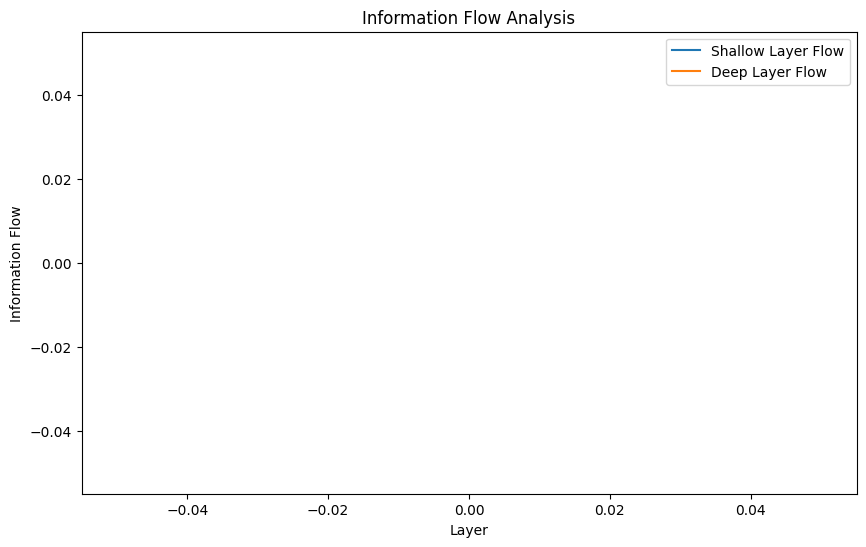

TypeError: only integer tensors of a single element can be converted to an index

In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import numpy as np

class LabelWordAnalyzer:
    def __init__(self, model_name: str = "gpt2"):
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def prepare_input(self, demonstrations: List[Dict], query: str) -> torch.Tensor:
        """Format input with demonstrations and query."""
        prompt = ""
        for demo in demonstrations:
            prompt += f"Text: {demo['text']}\nLabel: {demo['label']}\n\n"
        prompt += f"Text: {query}\nLabel:"
        
        inputs = self.tokenizer(prompt, return_tensors="pt")
        return inputs.to(self.device)

    def compute_attention_flow(self, input_ids: torch.Tensor, 
                             label_positions: List[int]) -> Dict[str, torch.Tensor]:
        """Compute attention flow metrics for shallow and deep layers."""
        outputs = self.model(input_ids, output_attentions=True)
        attentions = outputs.attentions
        
        # Track information flow metrics
        shallow_flow = self._compute_layer_flow(attentions[:len(attentions)//2], 
                                              label_positions)
        deep_flow = self._compute_layer_flow(attentions[len(attentions)//2:], 
                                           label_positions)
        
        return {
            "shallow_flow": shallow_flow,
            "deep_flow": deep_flow
        }

    def _compute_layer_flow(self, attention_maps: Tuple[torch.Tensor], 
                           label_positions: List[int]) -> torch.Tensor:
        """Compute information flow for a set of layers."""
        flow = torch.zeros(len(attention_maps))
        for i, attn in enumerate(attention_maps):
            # Calculate flow to/from label positions
            label_flow = attn[0, :, :, label_positions].mean()
            flow[i] = label_flow
        return flow

    def compute_loyalty_metrics(self, base_logits: torch.Tensor, 
                              modified_logits: torch.Tensor) -> Dict[str, float]:
        """Compute label and word loyalty metrics."""
        # Label loyalty
        base_pred = base_logits.argmax(dim=-1)
        mod_pred = modified_logits.argmax(dim=-1)
        label_loyalty = (base_pred == mod_pred).float().mean().item()

        # Word loyalty (top-5 overlap)
        base_top5 = torch.topk(base_logits, k=5, dim=-1).indices[0]
        mod_top5 = torch.topk(modified_logits, k=5, dim=-1).indices[0]
        word_overlap = len(set(base_top5.tolist()) & set(mod_top5.tolist())) / 5

        return {
            "label_loyalty": label_loyalty * 100,
            "word_loyalty": word_overlap * 100
        }

    def block_information_flow(self, layer_idx: int, 
                             attention_mask: torch.Tensor) -> None:
        """Block information flow in specified layer."""
        def attention_hook(module, input_tensor, output_tensor):
            modified_attention = output_tensor * attention_mask
            return modified_attention
        
        # Register hook
        layer = self.model.transformer.h[layer_idx].attn
        handle = layer.register_forward_hook(attention_hook)
        return handle

    def visualize_flow(self, flow_metrics: Dict[str, torch.Tensor], 
                    title: str = "Information Flow Analysis"):
        """Visualize information flow patterns."""
        plt.figure(figsize=(10, 6))
        
        layers = np.arange(len(flow_metrics["shallow_flow"]))
        # Detach tensors and move to CPU before plotting
        shallow_flow = flow_metrics["shallow_flow"].detach().cpu().numpy()
        deep_flow = flow_metrics["deep_flow"].detach().cpu().numpy()
        
        plt.plot(layers, shallow_flow, label="Shallow Layer Flow")
        plt.plot(layers, deep_flow, label="Deep Layer Flow")
        
        plt.xlabel("Layer")
        plt.ylabel("Information Flow")
        plt.title(title)
        plt.legend()
        plt.show()

# Example usage
def main():
    # Initialize analyzer
    analyzer = LabelWordAnalyzer()

    # Prepare demonstration data
    demonstrations = [
        {"text": "This movie was amazing!", "label": "positive"},
        {"text": "I really hated this film.", "label": "negative"},
        {"text": "A beautiful masterpiece.", "label": "positive"}
    ]
    query = "The plot was confusing and boring."

    # Get inputs and label positions
    inputs = analyzer.prepare_input(demonstrations, query)
    label_positions = [i for i, tok in enumerate(inputs["input_ids"][0]) 
                      if tok in analyzer.tokenizer.encode(["positive", "negative"])]

    # Compute baseline flow
    flow_metrics = analyzer.compute_attention_flow(inputs["input_ids"], 
                                                 label_positions)
    analyzer.visualize_flow(flow_metrics)

    # Analyze with blocked information flow
    attention_mask = torch.ones_like(inputs["attention_mask"])
    attention_mask[:, label_positions] = 0
    
    handle = analyzer.block_information_flow(0, attention_mask)
    outputs_blocked = analyzer.model(**inputs)
    handle.remove()

    # Compute loyalty metrics
    outputs_normal = analyzer.model(**inputs)
    loyalty = analyzer.compute_loyalty_metrics(outputs_normal.logits, 
                                            outputs_blocked.logits)
    print("Loyalty Metrics:", loyalty)

if __name__ == "__main__":
    main()